<a href="https://colab.research.google.com/github/Chidiebere-Ogbuchi/TSP_CausalDiscovery/blob/main/CausalDiscovery_GES_v4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### CAUSAL DISCOVERY - Greedy Equivalence Search
 * This notebook is used for testing the GES with the BIC score or generalized score for Causal Discovery using Py-Why
 * The  Algorithm is a Score-Based Algorithm method for inferring causal relationships from observational data.
 * It is commonly used in the field of causal inference and can help identify cause-effect relationships between variables in a dataset.
 * For more information on the Peter-Clark Algorithm and how to get started with causal inference, please refer to the documentation at: [https://causal-learn.readthedocs.io/en/latest/getting_started.html](https://causal-learn.readthedocs.io/en/latest/getting_started.html)


In [1]:
!pip install -r requirement.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 174.5/174.5 kB 3.3 MB/s eta 0:00:00


In [7]:
import os, time
import sys
sys.path.append("")
import unittest
import hashlib
import numpy as np
from causallearn.search.ConstraintBased.PC import pc
from causallearn.utils.cit import chisq, fisherz, gsq, kci, mv_fisherz, d_separation
from causallearn.graph.SHD import SHD
from causallearn.utils.DAG2CPDAG import dag2cpdag
from causallearn.utils.TXT2GeneralGraph import txt2generalgraph
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import pickle
from causallearn.search.ScoreBased.GES import ges
from causallearn.score.LocalScoreFunction import local_score_BIC
import io
import matplotlib.image as mpimg
# from .utils_simulate_data import simulate_discrete_data, simulate_linear_continuous_data

# or save the graph
from causallearn.utils.GraphUtils import GraphUtils

from causallearn.search.ConstraintBased.PC import pc

### LOADING DATASET

In [8]:
# Load data
def load_data_save_to_txt():
    """
    Load data from either a pickle file or a CSV file and save it to a text file.

    Returns:
        pandas.DataFrame: The loaded data.
    """
    pickle_file_path = "./data/output.p"
    csv_file_path = "./data/output.csv"
    txt_file_path = './data/output.txt'

    if os.path.exists(pickle_file_path):
        df = pd.read_pickle(pickle_file_path)
    else:
        df = pd.read_csv(csv_file_path)
        df.to_pickle(pickle_file_path, protocol=pickle.HIGHEST_PROTOCOL)

    df.to_csv(txt_file_path, sep='\t', index=False)

    return df


In [9]:
# View the first few rows of the data
try:
    df = load_data_save_to_txt()
    df.head()
except Exception as e:
    print(f"Csv or Pickle file not found")


In [10]:
## Load data for Causal Discovery from a txt file
def load_txt_dag_data(data_path, num_rows):
    """
    Load data from a text file.

    Args:
        data_path (str): Path to the data file.
        num_rows (int): Number of rows to load from the data file. If None, all rows will be loaded.

    Returns:
        numpy.ndarray: The loaded data as a numpy array.
    """
    full_data = np.loadtxt(data_path, skiprows=1)

    # Randomly select num_rows rows
    if num_rows is not None:
        indices = np.random.choice(full_data.shape[0], num_rows, replace=False)
        data = full_data[indices, :]
    else:
        data = full_data

    return data

## Load Ground Truth Directed Acyclic Graph (DAG)
def load_truth_dag(truth_graph_path):
    """
    Load the ground truth directed acyclic graph (DAG) from a text file.

    Args:
        truth_graph_path (str): Path to the truth graph file.

    Returns:
        Graph: The loaded truth DAG.
    """

    truth_dag = txt2generalgraph(truth_graph_path)
    return truth_dag

# Usage example:
# Load data
data_path = "./data/output.txt"   # "output.txt"
truth_graph_path = "./data/graph.10.txt"
num_rows = None #select number of rows to load or None

data = load_txt_dag_data(data_path, num_rows)

In [19]:
# txt_file_path = 'your_file.txt'

# Read the first line of the text file
with open(data_path, 'r') as file:
    first_line = file.readline().strip()  # Read the first line and remove leading/trailing whitespace

# Assuming the header is separated by commas, split the line based on the delimiter
header = first_line.split('\t')

# Print or use the header
print(header)


['bandwidth', 'responsetime', 'visitors', 'observation_value', 'location_encoded']


### RUNNING ALGORITHM

In [29]:
from causallearn.search.ScoreBased.GES import ges

def run_ges(data, score_func="local_score_BIC", maxP=3, parameters={"kfold": 5, "lambda": 0.1, "dlabel": None}):
    """
    Run the GES algorithm for causal discovery.

    Parameters:
    - data: The input data for causal discovery.
    - score_func: The score function to be used for evaluating the quality of causal graphs. Default is "local_score_BIC".
        # “local_score_BIC”: BIC score 3.
        # “local_score_BDeu”: BDeu score 4.
        # “local_score_cv_general”: Generalized score with cross validation for data with single-dimensional variables 2.
        # “local_score_marginal_general”: Generalized score with marginal likelihood for data with single-dimensional variables 2.
        # “local_score_cv_multi”: Generalized score with cross validation for data with multi-dimensional variables 2.
        # “local_score_marginal_multi”: Generalized score with marginal likelihood for data with multi-dimensional variables 2.
    - maxP: The maximum number of parents for each variable. Default is 3.
    - parameters: Additional custom parameters for the GES algorithm. Default is {"kfold": 5, "lambda": 0.1, "dlabel": None}.

    Returns:
    - Record: The result of the GES algorithm, including the learned causal graph.

    Example usage:
    data = ...  # Load your data here
    Record = run_ges(data)
    """
    Record = ges(data, score_func, maxP, parameters)

    # Visualization using PyDot
    pyd = GraphUtils.to_pydot(Record['G'], labels=header)
    tmp_png = pyd.create_png(f="png")
    fp = io.BytesIO(tmp_png)
    img = mpimg.imread(fp, format='png')
    plt.axis('off')
    plt.imshow(img)
    plt.show()

    # Alternatively, save the graph to a file
    pyd.write_png('GES_test.png')

    return Record

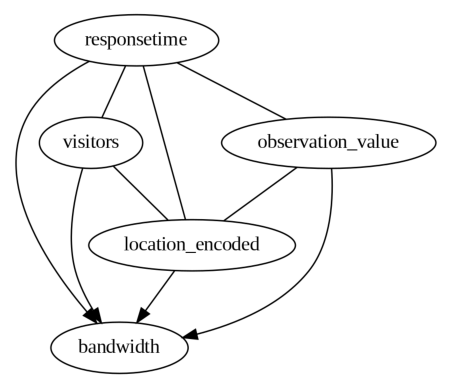

In [30]:
#Parameters
score_func = "local_score_BIC"
maxP = 3
parameters = {"kfold": 5, "lambda": 0.1, "dlabel": None}


# Run the GES algorithm
Record = run_ges(data=data, score_func=score_func, maxP=maxP, parameters=parameters)




# ‘cg.draw_pydot_graph(labels=[“A”, “B”, “C”])’
# ‘GraphUtils.to_pydot(cg.G, labels=[“A”, “B”, “C”])’

In [35]:
# Extract the learned causal graph
learned_graph = Record['G']

# Print or use the learned graph
# print(learned_graph)

# Define the path where the learned graph will be saved
txt_file_path = 'GES_learned_graph.txt'

# Save the learned graph to a text file in truth format
with open(txt_file_path, 'w') as file:
    file.write(str(learned_graph))

# print(f'Learned graph saved to {txt_file_path}.')

# # Define the path of the text file
# txt_file_path = 'GES_learned_graph.txt'

# Read the content of the text file
with open(txt_file_path, 'r') as file:
    graph_output = file.read()

# Define the list of variable names
# variable_names = ['bandwidth', 'responsetime', 'visitors', 'observation_value', 'location_encoded']

# Replace the placeholders with the variable names in the graph output
graph_output = graph_output.replace('X1', header[0])
graph_output = graph_output.replace('X2', header[1])
graph_output = graph_output.replace('X3', header[2])
graph_output = graph_output.replace('X4', header[3])
graph_output = graph_output.replace('X5', header[4])

# Save the modified content back to the same file
with open(txt_file_path, 'w') as file:
    file.write(graph_output)

print(graph_output)
print(f'Modified graph content saved back to {txt_file_path}.')


Graph Nodes:
bandwidth;responsetime;visitors;observation_value;location_encoded

Graph Edges:
1. responsetime --> bandwidth
2. visitors --> bandwidth
3. observation_value --> bandwidth
4. location_encoded --> bandwidth
5. responsetime --- visitors
6. responsetime --- observation_value
7. responsetime --- location_encoded
8. visitors --- location_encoded
9. observation_value --- location_encoded

Modified graph content saved back to GES_learned_graph.txt.


### Testing Conditional independence Test methods

In [36]:
## Testing Conditional independence Test methods
from causallearn.utils.cit import CIT
mv_fisherz_obj = CIT(data, "fisherz") # construct a CIT instance with data and method name
# “fisherz”, “chisq”, “gsq”, “kci”, “mv_fisherz”
# pValue = mv_fisherz_obj(X, Y, S) # X, Y and condition_set : column indices of data
pValue = mv_fisherz_obj(4, 3, [1, 2])
print(pValue)


0.0


In [37]:
## Testing Score Functions
# Local Score BIC
from causallearn.score.LocalScoreFunction import local_score_BIC
i = 3
PAi = [4]
parameters = {"lambda_value": 15}

score = local_score_BIC(data, i, PAi, parameters=parameters)

print(score)

[[17138.68218467]]


In [14]:
# Local Score BDEu
from causallearn.score.LocalScoreFunction import local_score_BDeu

i = 2
PAi = [4]

# Set the number of states for the random variables X_i and its parent variables
r_i_map = {i: 2, 4: 3}  # Replace 2 and 3 with the actual number of states for X_i and X_4

# Include the keys in the parameters dictionary with default values
parameters = {"sample_prior": True, "structure_prior": 1.0, "r_i_map": r_i_map}

score = local_score_BDeu(data, i, PAi, parameters)
print(score)


850981.5378683452


In [ ]:
# Local Score CV General
from causallearn.score.LocalScoreFunction import local_score_cv_general

# Replace Xi and PAi with the actual values
Xi = 3
PAi = [4]

# Set the parameters
parameters = {"kfold": 5, "lambda": 0.1}

# Call the local_score_cv_general function
score = local_score_cv_general(data, Xi, PAi, parameters)

# Print the result
print(score)


### Testing Metrics
##### Use only loading a ground-truth


In [ ]:
 # Load
from causallearn.graph.ArrowConfusion import ArrowConfusion
from causallearn.graph.AdjacencyConfusion import AdjacencyConfusion
from causallearn.graph.SHD import SHD

## Testing SHD against Truth Graph
print('Now start test_pc_load_linear_10_with_fisher_z ...')
truth_dag = load_truth_dag(truth_graph_path)
truth_dag = txt2generalgraph(truth_graph_path) # truth_dag is a GeneralGraph instance
truth_cpdag = dag2cpdag(truth_dag)
num_edges_in_truth = truth_dag.get_num_edges()

# Run PC with default parameters: stable=True, uc_rule=0 (uc_sepset), uc_priority=2 (prioritize existing colliders)
# Record = run_ges(data)# Run PC and obtain the estimated graph (cg is CausalGraph object)
# benchmark_returned_graph = np.loadtxt("tests/TestData/benchmark_returned_results/linear_10_pc_fisherz_0.05_stable_0_2.txt")
# assert np.all(cg.G.graph == benchmark_returned_graph), INCONSISTENT_RESULT_GRAPH_ERRMSG

est = learned_graph

# For arrows
arrow = ArrowConfusion(truth_cpdag, est)

arrowsTp = arrow.get_arrows_tp()
arrowsFp = arrow.get_arrows_fp()
arrowsFn = arrow.get_arrows_fn()
arrowsTn = arrow.get_arrows_tn()

arrowPrec = arrow.get_arrows_precision()
arrowRec = arrow.get_arrows_recall()

# For adjacency matrices
adj = AdjacencyConfusion(truth_cpdag, est)

adjTp = adj.get_adj_tp()
adjFp = adj.get_adj_fp()
adjFn = adj.get_adj_fn()
adjTn = adj.get_adj_tn()

adjPrec = adj.get_adj_precision()
adjRec = adj.get_adj_recall()

# Structural Hamming Distance
shd = SHD(truth_cpdag, est)

print(f"    pc(data, 0.05, fisherz)\tSHD: {shd.get_shd()} of {num_edges_in_truth}")
print(f"    pc(data, 0.05, fisherz)\tArrow Precision: {arrowPrec}")
print(f"    pc(data, 0.05, fisherz)\tArrow Recall: {arrowRec}")
print(f"    pc(data, 0.05, fisherz)\tAdjacency Precision: {adjPrec}")
print(f"    pc(data, 0.05, fisherz)\tAdjacency Recall: {adjRec}")


Now start test_pc_load_linear_10_with_fisher_z ...
    pc(data, 0.05, fisherz)	SHD: 13 of 30
    pc(data, 0.05, fisherz)	Arrow Precision: 0.7241379310344828
    pc(data, 0.05, fisherz)	Arrow Recall: 0.8076923076923077
    pc(data, 0.05, fisherz)	Adjacency Precision: 0.8620689655172413
    pc(data, 0.05, fisherz)	Adjacency Recall: 0.8333333333333334
